# CNN with reduced features from dataset and generated features

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/combined_reduced.csv')

In [3]:
X1 = np.load('../datasets/final_X.npy')

In [4]:
# Convert the DataFrame to a NumPy array
df_array = df.to_numpy()

# Stack the DataFrame and the NumPy array horizontally
X_final = np.hstack((df_array, X1))

In [5]:
target = pd.read_csv('../datasets/kag_red.csv')

In [6]:
from sklearn.model_selection import train_test_split

y = target['subreddit']  # Target

In [7]:
# merge X_final and y to single dataframe
df_final = pd.DataFrame(X_final)
df_final['subreddit'] = y

In [8]:
import pandas as pd
import numpy as np

# Get indexes of rows where subreddit is 'depression'
depression_rows = df_final[df_final['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.57)  # 57% of the rows to keep

# Randomly select 57% of the rows to keep
rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

# Remove 43% of rows with subreddit 'depression' 
df_final.drop(rows_to_remove_indexes, inplace=True)

# Now df contains 57% of the original 'depression' rows randomly selected and all other rows intact


In [9]:

X_final_d = df_final.drop('subreddit', axis=1)
y_final_d = df_final['subreddit']


In [10]:
# convert X_final_d and y_final_d to numpy arrays
X_final_d = X_final_d.to_numpy()

In [11]:
# print the shape of X_final and y
print(X_final_d.shape)
print(y_final_d.shape)

(324046, 1140)
(324046,)


In [12]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_d, y_final_d, test_size=0.2, random_state=42)


In [13]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_val_encoded = y_val_encoded.argmax(axis=1)
y_test_encoded = y_test_encoded.argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded) 
y_val_encoded = to_categorical(y_val_encoded) 
y_test_encoded_cat = to_categorical(y_test_encoded)


## Compiling and training the model

In [15]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CNN_reduced.ipynb'

In [16]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score
import numpy as np

wandb.init(project='Best_Models', name='CNN_d_reduced')


params = {
    'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 200, 'act': 'tanh'
}

wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [17]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 3 or epoch == 6:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_relu_{}.hd5".format(epoch))

In [18]:
import tensorflow as tf

model = Sequential()
model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['act'],
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=params['pool_size']))
model.add(Flatten())
model.add(Dense(params['dense_units'], activation=params['act']))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

saver = CustomSaver()

history = model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=16,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               WandbCallback(), saver])

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)

accr = model.evaluate(X_test_reshaped, y_test_encoded_cat)

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'validation_loss': history.history['val_loss'][len(history.history['val_loss']) - 1], 'epoch': len(history.history['val_loss'])})





wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
12148/12152 [============================>.] - ETA: 0s - loss: 1.0275 - accuracy: 0.6533

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 60s 5ms/step - loss: 1.0275 - accuracy: 0.6533 - val_loss: 0.8750 - val_accuracy: 0.6997
Epoch 2/10
12150/12152 [============================>.] - ETA: 0s - loss: 0.8517 - accuracy: 0.7058

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 56s 5ms/step - loss: 0.8516 - accuracy: 0.7059 - val_loss: 0.8377 - val_accuracy: 0.7128
Epoch 3/10
12143/12152 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.7147

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 59s 5ms/step - loss: 0.8228 - accuracy: 0.7147 - val_loss: 0.8237 - val_accuracy: 0.7139
Epoch 4/10
12151/12152 [============================>.] - ETA: 0s - loss: 0.8047 - accuracy: 0.7199

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


12152/12152 [==============================] - 60s 5ms/step - loss: 0.8047 - accuracy: 0.7199 - val_loss: 0.8075 - val_accuracy: 0.7191
Epoch 5/10
12143/12152 [============================>.] - ETA: 0s - loss: 0.7905 - accuracy: 0.7243

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 60s 5ms/step - loss: 0.7904 - accuracy: 0.7243 - val_loss: 0.8046 - val_accuracy: 0.7214
Epoch 6/10
12152/12152 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.7273

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 62s 5ms/step - loss: 0.7785 - accuracy: 0.7273 - val_loss: 0.7967 - val_accuracy: 0.7212
Epoch 7/10
12152/12152 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.7300

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


12152/12152 [==============================] - 63s 5ms/step - loss: 0.7685 - accuracy: 0.7300 - val_loss: 0.7881 - val_accuracy: 0.7251
Epoch 8/10
12147/12152 [============================>.] - ETA: 0s - loss: 0.7587 - accuracy: 0.7322

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s


12152/12152 [==============================] - 62s 5ms/step - loss: 0.7587 - accuracy: 0.7322 - val_loss: 0.7829 - val_accuracy: 0.7268
Epoch 9/10
12146/12152 [============================>.] - ETA: 0s - loss: 0.7499 - accuracy: 0.7356

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_175826-tkc4bzwl/files/model-best)... Done. 0.1s
wandb: Network error (ConnectionError), entering retry loop.


12152/12152 [==============================] - 80s 7ms/step - loss: 0.7499 - accuracy: 0.7356 - val_loss: 0.7798 - val_accuracy: 0.7280
Epoch 10/10
2026/2026 [==============================] - 3s 1ms/step - loss: 0.7830 - accuracy: 0.7259


In [15]:


# Save X_test_reshaped and y_test_encoded_cat to numpy arrays

np.save('../inferencing/data/X_test_CNN_reduced.npy', X_test_reshaped)
np.save('../inferencing/data/y_test_encoded_CNN_reduced.npy', y_test_encoded)

## Results

In [19]:

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.7258756364758525
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1518
           1       0.86      0.88      0.87      9254
           2       0.82      0.73      0.78      1229
           3       0.80      0.82      0.81     11512
           4       0.74      0.78      0.76      1774
           5       0.69      0.69      0.69      4868
           6       0.60      0.60      0.60     13369
           7       0.69      0.64      0.66      4704
           8       0.80      0.63      0.71      1696
           9       0.75      0.60      0.67      1709
          10       0.70      0.73      0.71     13177

    accuracy                           0.73     64810
   macro avg       0.75      0.71      0.73     64810
weighted avg       0.73      0.73      0.73     64810



In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix in percentage of total test samples
cm = confusion_matrix(y_test_encoded, y_pred_classes)


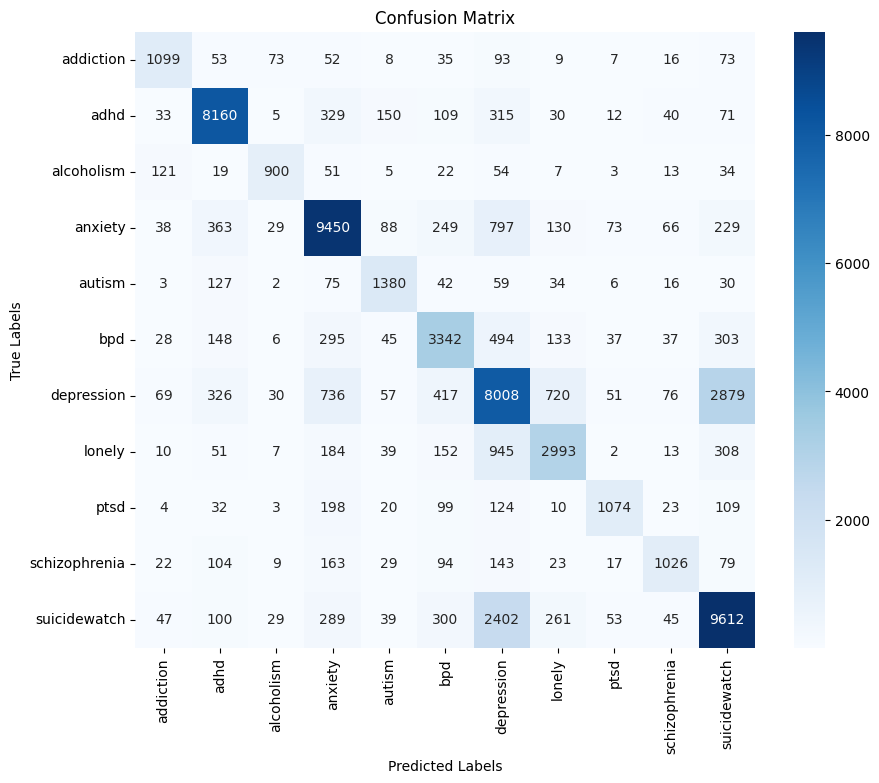

In [21]:


# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [22]:
# print count of categories in y_test
print(y_test.value_counts())

subreddit
depression       13369
suicidewatch     13177
anxiety          11512
adhd              9254
bpd               4868
lonely            4704
autism            1774
schizophrenia     1709
ptsd              1696
addiction         1518
alcoholism        1229
Name: count, dtype: int64


In [23]:
wandb.finish()

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▃▃▂▂▂▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▆▇██▇
val_loss,█▅▄▃▃▂▂▁▁▁
validation_loss,▁
accuracy,0.73792
best_epoch,8
best_val_loss,0.77981


In [24]:
del model